In [1]:
#----------------------------------------------
# Import packages
#----------------------------------------------
import os
import os.path
from os import path
import sys
import math
import random
import time
import pdb
import operator 
import copy
import numpy as np
import matplotlib.pyplot as plt
from numpy import matlib as mb
import torch
from envs import *
from my_utils import *
from state_action import *
from decision_making import *
from training import *
from bandit_function import *
np.set_printoptions(linewidth=250)
np.set_printoptions(formatter={'int': '{:2d}'.format})
np.set_printoptions(formatter={'float': '{:6.3f}'.format})

In [2]:
#----------------------------------------------
# Initialization
#----------------------------------------------
#random.seed(12312)
#np.random.seed(312321)
Netw_topo_id = 4                       # Network topology
flag_clear_past_bandit_results = False # Clear history of past bandit learning
if flag_clear_past_bandit_results:
    LOOP_Training_Bandit = 0
else:
    LOOP_Training_Bandit = 2 # Number of offline training of bandit
LOOP_Testing = 4             # Number of testing bandit
LOOP = LOOP_Training_Bandit + LOOP_Testing # Numer of realization
slots_monitored = 2000;        # Total time slots to be monitored
env_parameter = env_init(Netw_topo_id) # Enviroment parameters
t_slot = env_parameter.t_slot          # Time duration for a single slot in seconds
output_folder = 'output_net'+str(Netw_topo_id)+'/' # output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
print('Total time monitored is %0.2f seconds' %(slots_monitored*t_slot))
print('Total time for bandit training is %0.2f minutes' %(slots_monitored*t_slot*LOOP_Training_Bandit/60))

Total time monitored is 80.00 seconds
Total time for bandit training is 2.67 minutes


In [3]:
#----------------------------------------------
# All algorithms settings
#----------------------------------------------
scheme_setting_list = list();
class def_scheme_setting:
    def __init__(self):
        self.scheme_id = 0;
        self.Is_bandit_relay = False;
        self.Is_bandit_bw = False;
        self.Is_heuristic_tracking = False;
        self.Is_RL = False;
        self.legend = 'Max-weight + no tracking + no relay + random bw';
        self.color = 'r';
        return
    
# Scheme 0: Max-weight + no tracking + no relay + random bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 0;
scheme_setting.Is_bandit_relay = False;
scheme_setting.Is_bandit_bw = False;
scheme_setting.Is_heuristic_tracking = False;
scheme_setting.Is_RL = False;
scheme_setting.legend = 'Max-weight + no tracking + no relay + random bw';
scheme_setting.color = 'r';
scheme_setting_list.append(scheme_setting);

# Scheme 1: Max-weight + no tracking + no relay + bandit bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 1;
scheme_setting.Is_bandit_relay = False;
scheme_setting.Is_bandit_bw = True;
scheme_setting.Is_heuristic_tracking = False;
scheme_setting.Is_RL = False;
scheme_setting.legend = 'Max-weight + no tracking + no relay + bandit bw';
scheme_setting.color = 'b';
scheme_setting_list.append(scheme_setting);

# Scheme 2: Max-weight + no tracking + bandit relay + random bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 2;
scheme_setting.Is_bandit_relay = True;
scheme_setting.Is_bandit_bw = False;
scheme_setting.Is_heuristic_tracking = False;
scheme_setting.Is_RL = False;
scheme_setting.legend = 'Max-weight + no tracking + bandit relay + random bw';
scheme_setting.color = 'c';
scheme_setting_list.append(scheme_setting);

# Scheme 3: Max-weight + heuristic tracking + no relay + random bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 3;
scheme_setting.Is_bandit_relay = False;
scheme_setting.Is_bandit_bw = False;
scheme_setting.Is_heuristic_tracking = True;
scheme_setting.Is_RL = False;
scheme_setting.legend = 'Max-weight + heuristic tracking + no relay + random bw';
scheme_setting.color = 'k';
scheme_setting_list.append(scheme_setting);

# Scheme 4: Max-weight + heuristic tracking + bandit relay + bandit bw (Our first proposal)
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 4;
scheme_setting.Is_bandit_relay = True;
scheme_setting.Is_bandit_bw = True;
scheme_setting.Is_heuristic_tracking = True;
scheme_setting.Is_RL = False;
scheme_setting.legend = 'Max-weight + heuristic tracking + bandit relay + bandit bw';
scheme_setting.color = 'm';
scheme_setting_list.append(scheme_setting);

# Scheme 5: Max-weight + heuristic tracking + no relay + bandit bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 5;
scheme_setting.Is_bandit_relay = False;
scheme_setting.Is_bandit_bw = True;
scheme_setting.Is_heuristic_tracking = True;
scheme_setting.Is_RL = False;
scheme_setting.legend = 'Max-weight + heuristic tracking + no relay + bandit bw';
scheme_setting.color = 'g';
scheme_setting_list.append(scheme_setting);

# Scheme 6: Max-weight + no tracking + bandit relay + bandit bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 6;
scheme_setting.Is_bandit_relay = True;
scheme_setting.Is_bandit_bw = True;
scheme_setting.Is_heuristic_tracking = False;
scheme_setting.Is_RL = False;
scheme_setting.legend = 'Max-weight + no tracking + bandit relay + bandit bw';
scheme_setting.color = 'y';
scheme_setting_list.append(scheme_setting);

# Scheme 7: Deep Reinforcement Learning (PPO)
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 7;
scheme_setting.Is_bandit_relay = False;
scheme_setting.Is_bandit_bw = False;
scheme_setting.Is_heuristic_tracking = False;
scheme_setting.Is_RL = True;
scheme_setting.legend = 'Deep Reinforcement Learning (PPO)';
scheme_setting.color = 'darkorange';
scheme_setting_list.append(scheme_setting);

In [4]:
#----------------------------------------------
# Result vectors
#----------------------------------------------
N_schemes = len(scheme_setting_list);
channel_X_history = np.zeros((slots_monitored,env_parameter.N_UE,env_parameter.N_UE));
Queue = np.zeros((LOOP,slots_monitored,env_parameter.N_UE,N_schemes));
Delay_dist = np.zeros((LOOP,slots_monitored+1,env_parameter.N_UE,N_schemes));
Throughput = np.zeros((LOOP,slots_monitored,env_parameter.N_UE,N_schemes));
UE_ID_evolution = np.zeros((slots_monitored,N_schemes));
npkts_arrival_evolution = np.zeros((LOOP,slots_monitored,env_parameter.N_UE,N_schemes));
npkts_departure_evolution = np.zeros((LOOP,slots_monitored,env_parameter.N_UE,N_schemes));
# Default state/action/output/banditBW/banditRelay list
state_list = list();
action_list = list();
output_list = list();
lastOutput_list = list();
bandit_bw_para_list = list();
bandit_relay_para_list = list();
env_list = list();
for scheme_id in range(N_schemes):
    bandit_bw_para_list.append(def_bandit_bw_parameter(env_parameter));
    bandit_relay_para_list.append(def_bandit_relay_parameter(env_parameter));
    state_list.append(def_state(env_parameter));
    action_list.append(def_action(env_parameter));
    output_list.append(def_output(env_parameter)); 
    lastOutput_list.append(def_output(env_parameter)); 
    env_list.append(envs(env_parameter,slots_monitored));

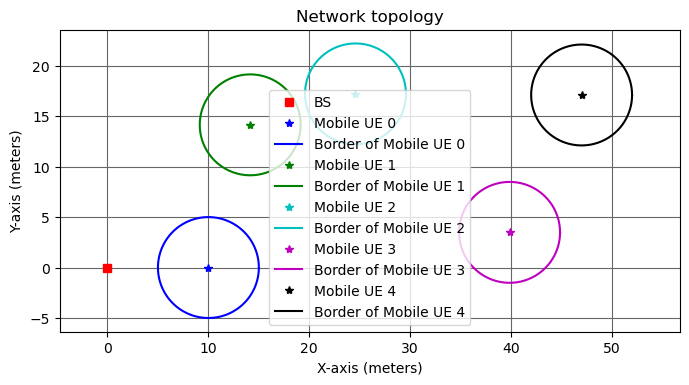

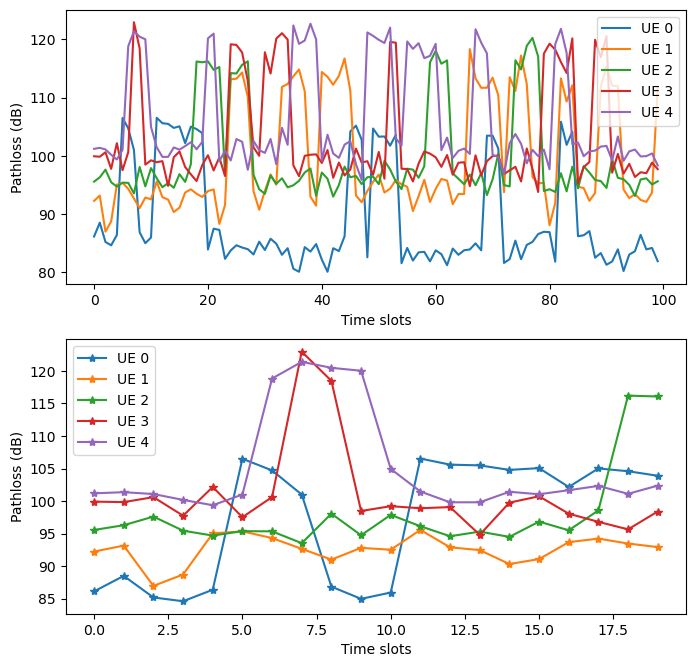

In [ ]:
#----------------------------------------------
# Evaluation
#----------------------------------------------
# Common enviroment for packet arrival and channel shadowing
envCommon = envs(env_parameter,slots_monitored);
plot_network_topology(envCommon.env_parameter,output_folder)

# Load trained DRL decision maker
loadpath = output_folder+'trained_model_netwTopo'+str(Netw_topo_id)+'.pt'
checkpoint = torch.load(loadpath)
DRL_Decision_Maker = checkpoint['model']
DRL_Decision_Maker.load_state_dict(checkpoint['model_state_dict'])
DRL_Decision_Maker.eval()

# Start evaluation
tStart = time.time()
for loop in range(LOOP):
    if flag_clear_past_bandit_results:
        bandit_bw_para_list.clear();
        bandit_relay_para_list.clear();
    state_list.clear();
    action_list.clear();
    lastOutput_list.clear();
    output_list.clear();
    env_list.clear();
    envCommon.reset();
    for scheme_id in range(N_schemes):
        if flag_clear_past_bandit_results:
            bandit_bw_para_list.append(def_bandit_bw_parameter(env_parameter));
            bandit_relay_para_list.append(def_bandit_relay_parameter(env_parameter));
        state_list.append(def_state(env_parameter));
        action_list.append(def_action(env_parameter));
        output_list.append(def_output(env_parameter));
        lastOutput_list.append(def_output(env_parameter)); 
        env_list.append(envs(env_parameter,slots_monitored));
    for scheme_id in range(N_schemes):
        env_list[scheme_id].is_external_packet_arrival_process = True
        env_list[scheme_id].external_npkts_arrival = envCommon.packet_arrival_process()
        state_list[scheme_id] = env_list[scheme_id].reset();
        
    # Loop of slots
    for ct in range(slots_monitored):  
        # Channel realization (Maybe to consider the correlation between time slots)
        channel = envCommon.channel_realization()
        envCommon.ct += 1
        # Common packet arrival process
        common_npkts_arrival = envCommon.packet_arrival_process()        
        
        # Loop of schemes
        for scheme_id in range(N_schemes):            
            # Decisiion making
            if scheme_setting_list[scheme_id].Is_RL:                
                input_state = state_list[scheme_id].to_ndarray_normalized()
                Vval, pi = DRL_Decision_Maker.forward(input_state)
                pi_dist = pi.detach().cpu().numpy()
                action_list[scheme_id], action_chosen_ndarray, action_chosen_index = \
                choose_action(pi_dist, env_list[scheme_id].env_parameter)
            else:
                decision_making(loop, ct, scheme_id, state_list, action_list, lastOutput_list,\
                                bandit_bw_para_list, bandit_relay_para_list, scheme_setting_list, \
                                env_list[scheme_id].env_parameter)
            
            # Sanity check of action
            action_sanity_check(ct, action_list[scheme_id], state_list[scheme_id])       

            # Interaction with enviroment
            last_state = copy.deepcopy(state_list[scheme_id]) 
            env_list[scheme_id].external_npkts_arrival = common_npkts_arrival
            state_list[scheme_id], output_list[scheme_id], reward, done = \
            env_list[scheme_id].step(state_list[scheme_id], action_list[scheme_id], channel)
            Queue[loop,ct,:,scheme_id] = env_list[scheme_id].Queue[ct,:]
            Delay_dist[loop,:,:,scheme_id] = env_list[scheme_id].delay_dist
            npkts_departure_evolution[loop,ct,:,scheme_id] = env_list[scheme_id].npkts_departure_evolution[ct,:]
            npkts_arrival_evolution[loop,ct,:,scheme_id] = env_list[scheme_id].npkts_arrival_evolution[ct,:]
            
            
            #----------------------------------------------
            # Following codes in loop in only for bandit algs
            #----------------------------------------------
            #Save last output
            lastOutput_list[scheme_id] = output_list[scheme_id];
            
            # History of UE selection
            UE_ID_evolution[ct,scheme_id] = action_list[scheme_id].UE_ID_BS2UE_Link;  
            
            # Update bandit vectors during during phase
            if loop < LOOP_Training_Bandit:
                bandit_relay_para_list[scheme_id] = \
                update_bandit_relay_para(bandit_relay_para_list[scheme_id],last_state,\
                                         action_list[scheme_id],output_list[scheme_id],\
                                         env_list[scheme_id].env_parameter);
                bandit_bw_para_list[scheme_id] = \
                update_bandit_bw_para(bandit_bw_para_list[scheme_id],\
                                      action_list[scheme_id],output_list[scheme_id],\
                                      env_list[scheme_id].env_parameter);

    # Plot channel evolution
    if loop == 0:
        fig = plt.figure(figsize=(8,8),dpi=100);   
        ax_pathloss = fig.add_subplot(211)
        ax_pathloss_detailed = fig.add_subplot(212)
        slots_show1 = 100
        slots_show2 = 20
        for u in range(envCommon.env_parameter.N_UE): 
            ax_pathloss.plot(range(slots_show1),env_list[7].pathloss_history[0:slots_show1,u,u]+\
                             envCommon.channel_X_history[0:slots_show1,u,u], label='UE '+str(u));
            ax_pathloss_detailed.plot(range(slots_show2),env_list[7].pathloss_history[0:slots_show2,u,u]+\
                                      envCommon.channel_X_history[0:slots_show2,u,u], '-*',label='UE '+str(u));
        ax_pathloss.set_xlabel('Time slots');
        ax_pathloss.set_ylabel('Pathloss (dB)');
        ax_pathloss.legend();
        ax_pathloss_detailed.set_xlabel('Time slots');
        ax_pathloss_detailed.set_ylabel('Pathloss (dB)');
        ax_pathloss_detailed.legend();
        plt.savefig(output_folder+'Pathloss_evolution.png', format='png', facecolor='w', transparent=False)
        plt.show();
elapsed = time.time() - tStart
time_per_loop = elapsed/LOOP
print('Time per loop %0.2f second' %time_per_loop)

##### PLOT RESULTS #####

In [ ]:
#----------------------------------------------
# Mean queue length
#----------------------------------------------
Queue_test = Queue[LOOP_Training_Bandit:,:,:,:]
Throughput_test = Throughput[LOOP_Training_Bandit:,:,:,:]
npkts_departure_evolution_test = npkts_departure_evolution[LOOP_Training_Bandit-1:-1,:,:,:]
Delay_dist_test = Delay_dist[LOOP_Training_Bandit:,:,:,:]
mean_queue_length = np.mean(Queue_test,axis=2);
max_queue_length = np.max(Queue_test,axis=2);
min_queue_length = np.min(Queue_test,axis=2);
mean_throughput = np.sum(Throughput_test,axis=2);
mean_pkts_departure_evolution = np.sum(npkts_departure_evolution_test,axis=2);
if LOOP > 1:
    mean_queue_length = np.mean(mean_queue_length,axis=0);
    max_queue_length = np.mean(max_queue_length,axis=0);
    min_queue_length = np.mean(min_queue_length,axis=0);
    mean_throughput = np.mean(mean_throughput,axis=0);
    mean_pkts_departure_evolution = np.mean(mean_pkts_departure_evolution,axis=0);

In [ ]:
#----------------------------------------------
# CDF of average queue length
#----------------------------------------------
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.loc': 'upper right'})
plt.figure(figsize=(8,8),dpi=100)
plt.title('CDF of Queue Length');
n_linspace = 100;
for scheme_id in range(N_schemes):
    [P, b] = cdf_dist_P_vs_b(mean_queue_length[:,scheme_id],n_linspace);
    plt.plot(b,P,label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Averaged queue length q');
plt.ylabel('Prob (queue length > q)');
plt.legend();
if flag_clear_past_bandit_results:
    plt.savefig(output_folder+'CDF_queue_length_pure_online.png',format='png', facecolor='w', transparent=False)
else:
    plt.savefig(output_folder+'CDF_queue_length.png',format='png', facecolor='w', transparent=False)
plt.show();

In [ ]:
#----------------------------------------------
# CDF of average queue length zoomed
#----------------------------------------------
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.loc': 'upper right'})
plt.figure(figsize=(8,8),dpi=100)
plt.title('CDF of Queue Length');
n_linspace = 100;
for scheme_id in ([2,4,6,7]):
    [P, b] = cdf_dist_P_vs_b(mean_queue_length[:,scheme_id],n_linspace);
    plt.plot(b,P,label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Averaged queue length q');
plt.ylabel('Prob (queue length > q)');
plt.legend();
if flag_clear_past_bandit_results:
    plt.savefig(output_folder+'CDF_queue_length_pure_online_zoom.png',format='png', facecolor='w', transparent=False)
else:
    plt.savefig(output_folder+'CDF_queue_length_zoom.png',format='png', facecolor='w', transparent=False)
plt.show();

In [ ]:
#----------------------------------------------
# Evolution of average queue length
#----------------------------------------------
plt.figure(figsize=(8,8),dpi=100)
plt.title('Evolution of average queue length')
slots_showed = slots_monitored;
for scheme_id in range(N_schemes):
    plt.plot(range(slots_showed),mean_queue_length[0:slots_showed,scheme_id],\
         label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Time slot index');
plt.ylabel('Average queue length');
plt.legend();
if flag_clear_past_bandit_results:
    plt.savefig(output_folder+'Evolution_queue_length_pure_online.png',format='png', facecolor='w', transparent=False)
else:
    plt.savefig(output_folder+'Evolution_queue_length.png',format='png', facecolor='w', transparent=False)
plt.show();

In [ ]:
#----------------------------------------------
# Evolution of average queue length zoomed
#----------------------------------------------
plt.figure(figsize=(8,8),dpi=100)
plt.title('Evolution of average queue length')
slots_showed = slots_monitored;
for scheme_id in ([4,6,7]):
    plt.plot(range(slots_showed),mean_queue_length[0:slots_showed,scheme_id],\
         label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Time slot index');
plt.ylabel('Average queue length');
plt.legend();
if flag_clear_past_bandit_results:
    plt.savefig(output_folder+'Evolution_queue_length_pure_online_zoom.png',format='png', facecolor='w', transparent=False)
else:
    plt.savefig(output_folder+'Evolution_queue_length_zoom.png',format='png', facecolor='w', transparent=False)
plt.show();

In [ ]:
#----------------------------------------------
# CDF of average delay length
#----------------------------------------------
ave_Delay_dist = np.squeeze(np.mean(np.mean(Delay_dist_test,axis=2),axis=0))
ave_Delay_dist = ave_Delay_dist/np.sum(ave_Delay_dist,axis=0)
ave_Delay_CDF = np.cumsum(ave_Delay_dist,axis=0)
plt.figure(figsize=(8,8),dpi=100)
plt.title('CDF of delay (slots)')
max_delay_to_show = slots_monitored+1
max_delay_to_show = 300
max_delay_to_show = min(max_delay_to_show,slots_monitored+1)
for scheme_id in range(N_schemes):
    plt.plot(range(max_delay_to_show),ave_Delay_CDF[0:max_delay_to_show,scheme_id],\
             label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Averaged delay in slots t')
plt.ylabel('Prob (delay <= t)')
plt.rcParams.update({'legend.loc': 'lower right'})
plt.legend()
if flag_clear_past_bandit_results:
    plt.savefig(output_folder+'CDF_delay_pure_online.png',format='png', facecolor='w', transparent=False)
else:
    plt.savefig(output_folder+'CDF_delay.png',format='png', facecolor='w', transparent=False)
plt.show()

In [ ]:
#----------------------------------------------
# CDF of average delay length
#----------------------------------------------
plt.figure(figsize=(8,8),dpi=100)
plt.title('CDF of delay (slots)')
max_delay_to_show = 50
max_delay_to_show = min(max_delay_to_show,slots_monitored+1)
#for scheme_id in range(N_schemes):
for scheme_id in ([2,4,6,7]):
    plt.plot(range(max_delay_to_show),ave_Delay_CDF[0:max_delay_to_show,scheme_id],\
             label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Averaged delay in slots t')
plt.ylabel('Prob (delay <= t)')
plt.rcParams.update({'legend.loc': 'lower right'})
plt.legend()
if flag_clear_past_bandit_results:
    plt.savefig(output_folder+'CDF_delay_pure_online_zoom.png',format='png', facecolor='w', transparent=False)
else:
    plt.savefig(output_folder+'CDF_delay_zoom.png',format='png', facecolor='w', transparent=False)
plt.show()

In [ ]:
# # Evolution of packet delivered
# plt.figure(figsize=(7,7),dpi=100)
# plt.title('Evolution of packet delivered');
# slots_showed = slots_monitored;
# for scheme_id in range(N_schemes):
#     plt.plot(range(slots_showed),mean_pkts_departure_evolution[0:slots_showed,scheme_id],\
#          label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
# plt.xlabel('Time slot index');
# plt.ylabel('Number of packets delivered');
# plt.legend();
# plt.show();

In [ ]:
# # Evolution of average system throughput
# mean_throughput_per_user = np.mean(Throughput,axis=0);
# plt.figure(figsize=(7,7),dpi=100)
# plt.title('evolution of average system throughput');
# slots_showed = slots_monitored;
# for scheme_id in [0,4]:
#     plt.plot(range(slots_showed),mean_throughput[0:slots_showed,scheme_id],\
#         label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
# #     plt.plot(range(slots_showed),mean_throughput_per_user[0:slots_showed,1,scheme_id],\
# #          label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
# plt.xlabel('Time slot index');
# plt.ylabel('Average system throughput');
# plt.legend();
# plt.show();

In [ ]:
#-------------------------------
# Save variable
#-------------------------------
testing_results_dict = {
    'flag_clear_past_bandit_results': flag_clear_past_bandit_results,
    'LOOP_Training_Bandit': LOOP_Training_Bandit,
    'LOOP_Testing': LOOP_Testing,
    'LOOP': LOOP,
    'slots_monitored': slots_monitored,
    'Netw_topo_id': Netw_topo_id,
    'output_folder': output_folder,
    'N_schemes': N_schemes,
    'time_per_loop': time_per_loop,
    'Queue': Queue,
    'Delay_dist': Delay_dist,
    'Throughput': Throughput,
    'UE_ID_evolution': UE_ID_evolution,
    'npkts_arrival_evolution': npkts_arrival_evolution,
    'npkts_departure_evolution': npkts_departure_evolution,
    'env_parameter': env_parameter,
    'scheme_setting_list': scheme_setting_list,
}
import pickle
testing_results_filename = 'testing_results_netwTopo'+str(Netw_topo_id)+'.dat'
outfile = open(testing_results_filename,'wb')
pickle.dump(testing_results_dict, outfile)
outfile.close()

In [ ]:
infile = open(testing_results_filename,'rb')
new_dict = pickle.load(infile)
infile.close()
print(new_dict['env_parameter'].Xcoor_init)
#print(new_env == env_parameter)
#print(new_scheme_setting_list==scheme_setting_list)

In [ ]:
arrival_per_UE =  env_parameter.lambda_vec * env_parameter.t_slot
print('\nTheoretical arrival per UE is \n', arrival_per_UE)
theo_arr_npkts = np.sum(env_parameter.lambda_vec * env_parameter.t_slot)
print('\nTheoretical arrival packets is: \n',theo_arr_npkts)
simulated_arr_npkts = np.mean(np.sum(npkts_arrival_evolution,axis=2))
print('\nSimulated arrival packets is: \n',theo_arr_npkts)
ave_depart_npkt = np.mean(np.mean(np.sum(npkts_departure_evolution[:,-100:-1,:,:],axis=2),axis=0),axis=0)
print('\nAverage departed packets/slot in last 100 slots\n',ave_depart_npkt)
final_queue_length = np.mean(np.mean(Queue[:,-1,:,:],axis=1),axis=0)
print('\nFinal average queue length is:\n', final_queue_length)
# Average delay in slots
np.sum(ave_Delay_dist[:,7] * np.asarray(range(2001))) 
print('Average delay in slots')
ave_delay_in_slots = np.sum(np.multiply(np.transpose(ave_Delay_dist),np.asarray(range(2001))),axis = 1)
print('\nAverage delay in slots is: \n', ave_delay_in_slots)

In [ ]:
decay_rate = 0.95
0.001*decay_rate**(1000/20)

In [ ]:
# from study_statistic import *
# slots = 200
# LOOP = 50
# outage, ue_velocity_vec, ue_selfrotate_vec, env_parameter = calculate_outage_statistic(slots, LOOP)
# plot_outage_trend(outage, ue_velocity_vec, ue_selfrotate_vec, env_parameter)

In [ ]:
# from study_statistic import *
# slots = 200
# LOOP = 50
# reff_statistic, final_eff_coeff, outage_coeff, env_parameter = calculate_ground_truth_optimal_beamwidth(slots, LOOP)
# plot_reff_statistic(reff_statistic, final_eff_coeff, outage_coeff, env_parameter)

In [ ]:
# from envs import *
# env_parameter = env_init(Netw_topo_id)
# plot_network_topology(env_parameter)